In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

### I. Interaction with categorical feature: the Africa rugged

In [ ]:
df = pd.read_csv("data/rugged.csv", delimiter=";")
df.shape

(234, 51)

In [ ]:
# Make log version of the outcome
df["log_gdp"] = np.log(df["rgdppc_2000"])

# Extract countries with GDP
dd = df.dropna(subset=["log_gdp"])
df.shape, dd.shape

((234, 52), (170, 52))

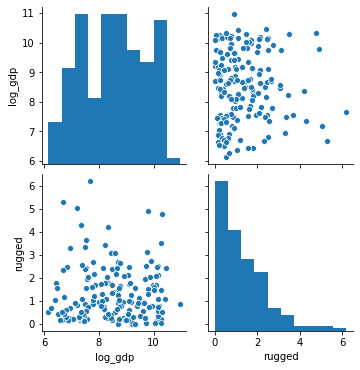

In [ ]:
sns.pairplot(data=dd[["log_gdp", "rugged"]])
plt.show()

In [ ]:
# Rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


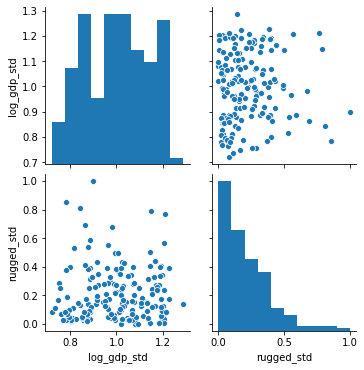

In [ ]:
sns.pairplot(data=dd[["log_gdp_std", "rugged_std"]])
plt.show()

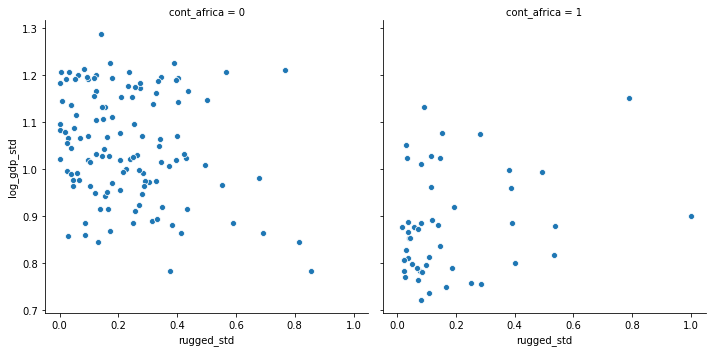

In [ ]:
sns.relplot(x="rugged_std", y="log_gdp_std",data=dd,col="cont_africa")

In [ ]:
dd[["log_gdp_std", "rugged_std"]].describe()

,log_gdp_std,rugged_std
count,170.000000,170.000000
mean,1.000000,0.214960
std,0.136959,0.188402
min,0.721556,0.000484
25%,0.885214,0.071308
50%,1.007176,0.157933
75%,1.113081,0.315584
max,1.287361,1.000000


### 1. Simple regression model m1

In [ ]:
with pm.Model() as m1:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.1)
    mu = a + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)
    
    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, 
                            observed=dd["log_gdp_std"])
    m1_prior = pm.sample_prior_predictive()
    m1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
az.summary(m1_trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,1.00,0.01,0.98,1.02
b,0.00,0.05,-0.09,0.09
sigma,0.14,0.01,0.12,0.15


### 2. Simple regression model with categorical or indexing m2

In [ ]:
cid = pd.Categorical(dd["cont_africa"])
cid

[1, 0, 0, 0, 0, ..., 0, 0, 1, 1, 1]
Length: 170
Categories (2, int64): [0, 1]

In [ ]:
with pm.Model() as m2:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.1)
    mu = a[cid] + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)
    
    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, 
                            observed=dd["log_gdp_std"])
    m2_prior = pm.sample_prior_predictive()
    m2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(m2_trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a[0],1.05,0.01,1.03,1.07
a[1],0.88,0.02,0.85,0.91
b,-0.04,0.04,-0.12,0.04
sigma,0.11,0.01,0.10,0.13


### 3. Simple regression model with categorical or indexing m3

In [ ]:
cid = pd.Categorical(dd["cont_africa"])
cid

[1, 0, 0, 0, 0, ..., 0, 0, 1, 1, 1]
Length: 170
Categories (2, int64): [0, 1]

In [ ]:
with pm.Model() as m3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)
    mu = a[cid] + b[cid] * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)
    
    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, 
                            observed=dd["log_gdp_std"])
    m3_prior = pm.sample_prior_predictive()
    m3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(m3_trace, kind="stats", round_to=2, credible_interval=89)

/opt/conda/lib/python3.7/site-packages/arviz/utils.py:653: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


,mean,sd,hdi_3%,hdi_97%
a[0],1.05,0.01,1.03,1.07
a[1],0.89,0.02,0.86,0.92
b[0],-0.14,0.06,-0.24,-0.04
b[1],0.13,0.07,-0.02,0.26
sigma,0.11,0.01,0.10,0.12


In [ ]:
with m3:
    m3_posterior = pm.sample_posterior_predictive(m3_trace, 
                                                  vars=[a, b, sigma])
    

/opt/conda/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/opt/conda/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


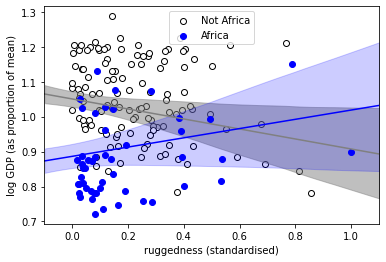

In [ ]:
fig, ax = plt.subplots()
rugged_plot = np.linspace(-0.1, 1.1)

ax.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)

pred0 = m3_posterior["a"][:, 0] + rugged_plot.reshape(-1, 1) * m3_posterior["b"][:,0]
ax.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax)

ax.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
pred1 = m3_posterior["a"][:, 1] + rugged_plot.reshape(-1, 1) * m3_posterior["b"][:,1]
ax.plot(rugged_plot, pred1.mean(1), color="b")
az.plot_hdi(rugged_plot, pred1.T, color="b", hdi_prob=0.97, ax=ax, fill_kwargs={"alpha": 0.2})

ax.legend(frameon=True)

ax.set_xlim(-0.1, 1.1)
ax.set_xlabel("ruggedness (standardised)")
ax.set_ylabel("log GDP (as proportion of mean)");

In [ ]:
az.compare({"m1":m1_trace, "m2":m2_trace, "m3":m3_trace}, ic="loo")

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m3,0,129.651,4.93649,0,0.816694,6.37146,0,False,log
m2,1,126.22,3.99458,3.43107,0.183306,7.40815,3.24757,False,log
m1,2,94.542,2.45781,35.1095,1.61585e-07,7.42805,7.49844,False,log


/opt/conda/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


(0.0, 1.0)

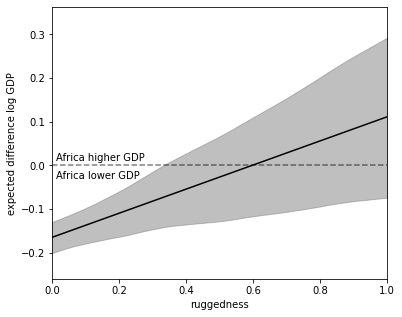

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

rugged_plot = np.linspace(-0.1, 1.1)

delta = pred1 - pred0  # using 'pred' from above

ax.plot(rugged_plot, delta.mean(1), c="k")
az.plot_hdi(rugged_plot, delta.T, ax=ax, color="grey")

ax.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
ax.text(0.01, 0.01, "Africa higher GDP")
ax.text(0.01, -0.03, "Africa lower GDP")

ax.set_xlabel("ruggedness")
ax.set_ylabel("expected difference log GDP")
ax.set_xlim(0, 1)


### II. Interaction with continuous feature: the Tulips case

In [ ]:
df = pd.read_csv("data/tulips.csv", delimiter=";")
df.shape

(27, 4)

In [ ]:
df.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [ ]:
df.describe()

,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


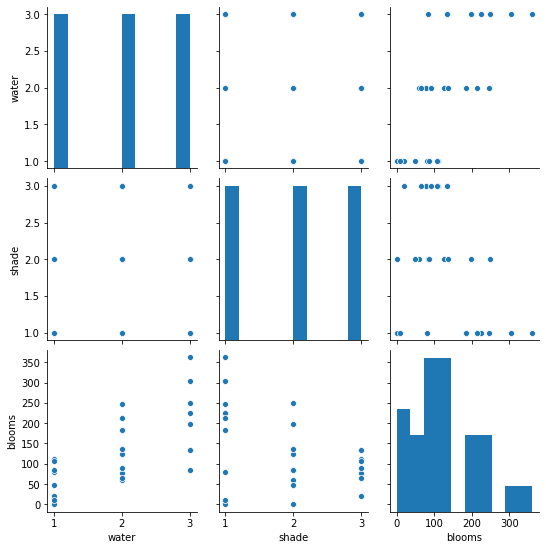

In [ ]:
sns.pairplot(df)
plt.show()

In [ ]:
df["blooms_std"] = df["blooms"] / df["blooms"].max()
df["water_cent"] = df["water"] - df["water"].mean()
df["shade_cent"] = df["shade"] - df["shade"].mean()

#### Without interaction

In [ ]:
with pm.Model() as c1:
    a = pm.Normal("a", 0, 1)
    bw = pm.Normal("bw", 0, 0.3)
    bs = pm.Normal("bs", 0, 0.3)
    mu = a + bw * df["water_cent"] + bs * df["shade_cent"]
    sigma = pm.Exponential("sigma", 1)
    
    blooms = pm.Normal("blooms", mu, sigma, observed=df["blooms_std"])
    
    c1_prior = pm.sample_prior_predictive()
    c1_trace = pm.sample()
    c1_postr = pm.sample_posterior_predictive(c1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
az.summary(c1_trace, credible_interval=90)

/opt/conda/lib/python3.7/site-packages/arviz/utils.py:653: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.357,0.035,0.291,0.424,0.001,0.0,4526.0,4419.0,4540.0,2787.0,1.0
bw,0.205,0.041,0.130,0.284,0.001,0.0,4636.0,4383.0,4613.0,2910.0,1.0
bs,-0.112,0.042,-0.189,-0.033,0.001,0.0,4745.0,4482.0,4763.0,2933.0,1.0
sigma,0.176,0.027,0.128,0.225,0.000,0.0,3319.0,3203.0,3429.0,2553.0,1.0


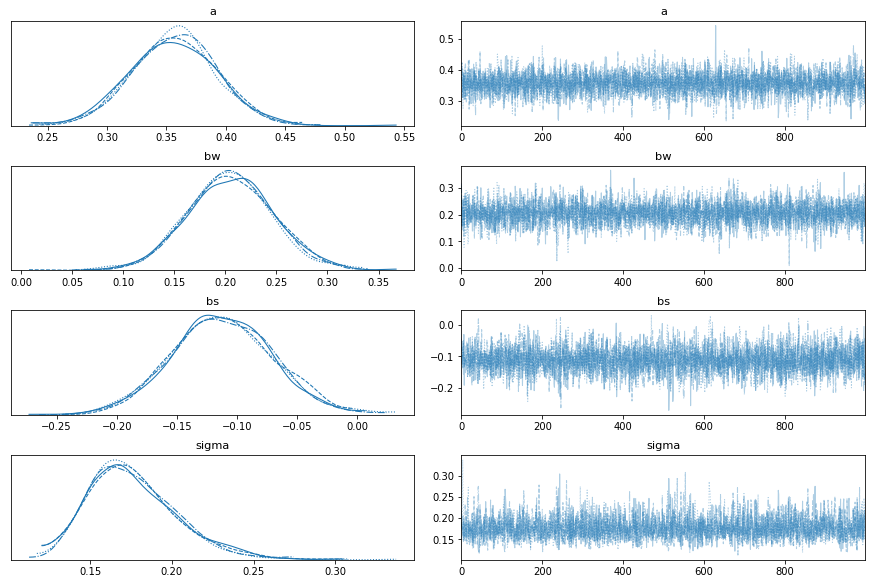

In [ ]:
pm.traceplot(c1_trace)
plt.show()

#### With interaction between shade and water

In [ ]:
with pm.Model() as c2:
    a = pm.Normal("a", 0, 1)
    bw = pm.Normal("bw", 0, 0.3)
    bs = pm.Normal("bs", 0, 0.3)
    bi = pm.Normal("bi", 0, 0.3)
    mu = a + bw * df["water_cent"] + bs * df["shade_cent"] + \
            bi * df["water_cent"] * df["shade_cent"] 
    sigma = pm.Exponential("sigma", 1)
    
    blooms = pm.Normal("blooms", mu, sigma, observed=df["blooms_std"])
    
    c2_prior = pm.sample_prior_predictive()
    c2_trace = pm.sample()
    c2_postr = pm.sample_posterior_predictive(c2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bi, bs, bw, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(c2_trace, credible_interval=90)

/opt/conda/lib/python3.7/site-packages/arviz/utils.py:653: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.356,0.027,0.303,0.407,0.000,0.0,4835.0,4796.0,4854.0,3161.0,1.0
bw,0.207,0.034,0.143,0.273,0.000,0.0,4828.0,4550.0,4860.0,2646.0,1.0
bs,-0.114,0.034,-0.176,-0.047,0.001,0.0,4464.0,3989.0,4480.0,2832.0,1.0
bi,-0.143,0.042,-0.223,-0.067,0.001,0.0,3815.0,3687.0,3887.0,2871.0,1.0
sigma,0.143,0.023,0.105,0.187,0.000,0.0,2816.0,2653.0,3053.0,2408.0,1.0


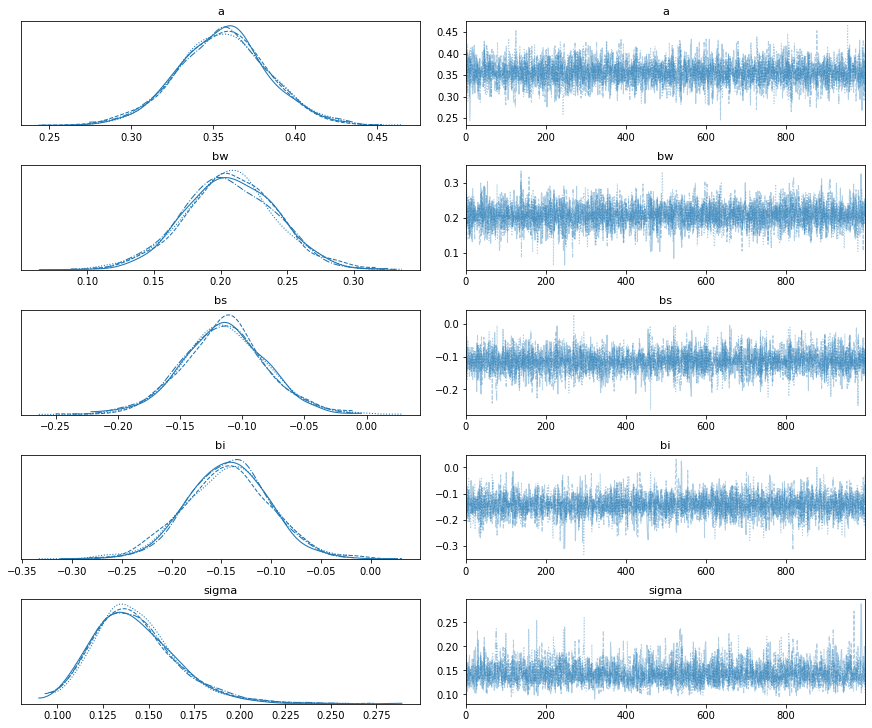

In [ ]:
pm.traceplot(c2_trace)
plt.show()